In [245]:
import tensorflow
import pandas as pd
import time
import numpy as np
import pylab as plt
import multiprocessing as mp
import statistics
from statistics import mean

import librosa
from librosa import feature
from glob import glob
import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D, Activation
from tensorflow.keras.callbacks import Callback
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
min_max_scaler = preprocessing.MinMaxScaler()

encoder = OneHotEncoder()

In [246]:
rootdir = '/Users/abhishekvaidyanathan/Desktop/NNDL-project/audio-files'
audio_files = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        audio_files.append(os.path.join(subdir, file))
audio_files = audio_files[1:]

In [247]:
dict_actors = {}
for audio_file in audio_files:
    try :
        if (len(dict_actors[audio_file[-33:-25]])>0):
            dict_actors[audio_file[-33:-25]].append(audio_file)
    except:
        dict_actors[audio_file[-33:-25]] = []
        dict_actors[audio_file[-33:-25]].append(audio_file)

In [248]:
data = pd.DataFrame(columns = ['Actor','Modality','Vocal_channel','Emotion','Emotional_intensity','Statement','Repetion','Gender','Audio_file'])

In [249]:
def get_gender(value):
    if(int(value)%2==0):
        return 1
    else :
        return 0

for keys in dict_actors:
    for files in dict_actors[keys]:
        data.loc[len(data)] = [keys,int(files[-24:-22]),int(files[-21:-19]),int(files[-18:-16]),int(files[-15:-13]),int(files[-12:-10]),int(files[-9:-7]),get_gender(files[-6:-4]),files]

In [311]:
def get_feature_vector(y, sr):
    result = []
    
    # multi-dim features
    result = []
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)
    # result=np.hstack((result, zcr)) # stacking horizontally
    result.extend(zcr)

    # Chroma_stft
    # stft = np.abs(librosa.stft(y))
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    result.extend(chroma_stft)
    # result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis=0)
    result.extend(mfcc)
    # result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
    result.extend(rms)
    # result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    result.extend(mel)
    
    # single-dim features with special requirements
    # feature_vector.append(np.mean(feature.rms(y=y)))
    # feature_vector.append(np.mean(feature.zero_crossing_rate(y=y)))
    result.extend([np.mean(x) for x in librosa.piptrack(y=y, sr=sr)])
    
    # single-dim features
    feat_list = [
        librosa.onset.onset_strength,
        feature.spectral_rolloff,
        feature.melspectrogram,
        feature.spectral_centroid,
        feature.spectral_bandwidth
    ]
    
    for temp_func in feat_list:
        result.append(np.mean(temp_func(y=y, sr=sr)))

# def fft_plot(audio, sampling_rate):
#     n=len(audio)
#     T=1/sampling_rate    
    yf=scipy.fft(y)    
    result.extend(yf)    
    # xf=np.linspace(0.0, 1.0/(2.0*T), int(n/2))
    # fig,ax = plt.subplots()
    # ax.plot(xf,2.0/n*np.abs(yf[:n//2]))
    # plt.grid()
    # plt.xlabel("Frequency -->")
    # plt.ylabel("Magnitude")
    # return plt.show()
    
    return result

In [ ]:
audio_features = []
for i in range(data.shape[0]):
   y , sr = librosa.load(data.iloc[i]['Audio_file'],sr=None)
   feature_vector = get_feature_vector(y, sr)
   audio_features.append(feature_vector)

In [301]:
from scipy.fftpack import fft,ifft
from scipy.io import wavfile as wav
rate, sr = wav.read(data.iloc[0]['Audio_file'])
xx,yy = librosa.load(data.iloc[0]['Audio_file'])
fft_out = fft(sr)

/var/folders/bf/k_40pbd90j3401sv0sntrcgw0000gn/T/ipykernel_7983/585319271.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, sr = wav.read(data.iloc[0]['Audio_file'])


In [308]:
X = librosa.stft(xx)
Xdb = librosa.amplitude_to_db(abs(X))

In [307]:
xx.shape

(86081,)

In [326]:
yf=fft(xx*w)    

In [327]:
yf.shape

(86081,)

In [325]:
from scipy.fft import fftfreq
from scipy.signal import blackman
w = blackman(len(xx))

In [330]:
xf = fftfreq(100, 1/yy)[:100//2]

In [331]:
xf.shape

(50,)

In [310]:
X.shape

(1025, 169)

In [309]:
Xdb.shape

(1025, 169)

In [332]:
X_train_features = pd.read_csv("./SER_data/X_train_features.csv")
X_test_features = pd.read_csv("./SER_data/X_test_features.csv")
y_train_features = pd.read_csv("./SER_data/y_train_features.csv")
y_test_features = pd.read_csv("./SER_data/y_test_features.csv")

In [211]:
X_train = pd.read_csv("./SER_data/X_train.csv")
X_test = pd.read_csv("./SER_data/X_test.csv")
y_train = pd.read_csv("./SER_data/y_train.csv")
y_test = pd.read_csv("./SER_data/y_test.csv")

In [333]:
X_train_cnn_features = np.expand_dims(X_train_features,axis=2)
X_test_cnn_features = np.expand_dims(X_test_features,axis=2)
y_train_cnn_features = encoder.fit_transform(np.array(y_train_features).reshape(-1,1)).toarray()
y_test_cnn_features = encoder.fit_transform(np.array(y_test_features).reshape(-1,1)).toarray()

In [212]:
X_train_cnn = np.expand_dims(X_train,axis=2)
X_test_cnn = np.expand_dims(X_test,axis=2)
y_train_cnn = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test_cnn = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [365]:
X_train_fourier = pd.read_csv("./SER_data/X_train_fourier.csv")
X_test_fourier = pd.read_csv("./SER_data/X_test_fourier.csv")
y_train_fourier = pd.read_csv("./SER_data/y_train_fourier.csv")
y_test_fourier = pd.read_csv("./SER_data/y_test_fourier.csv")

In [366]:
X_train_fourier_cnn = np.expand_dims(X_train_fourier,axis=2)
X_test_fourier_cnn = np.expand_dims(X_test_fourier,axis=2)
y_train_fourier_cnn = encoder.fit_transform(np.array(y_train_fourier).reshape(-1,1)).toarray()
y_test_fourier_cnn = encoder.fit_transform(np.array(y_test_fourier).reshape(-1,1)).toarray()

In [7]:
class time_for_batch(Callback):
    def on_train_begin(self, logs={}):
        self.times=[]
    def on_train_batch_begin(self, batch, logs={}):
        self.starttime = time.time()
    def on_train_batch_end(self, batch, logs={}):
        self.times.append(time.time()-self.starttime)
        
class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [396]:
def cnn_layers(no_folds,no_epochs,batch_size,X_train,y_train,X_test,y_test,epoch_times_dict):  

  kf = KFold(n_splits=no_folds,random_state=None, shuffle=False)
  KFold(n_splits=no_folds, random_state=None, shuffle=False)
  history_results = []

  # for train_index, test_index in kf.split(X_train):
  #   X_train_K, X_test_K = X_train[train_index], X_train[test_index]
  #   y_train_K, y_test_K = y_train[train_index], y_train[test_index]
  # model = Sequential()
  # input_size = X_train.shape[1]
  # model.add(Dense(64, input_shape=(input_size,), activation = "relu"))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.3))
  # model.add(Dense(64, activation = "relu"))
  # model.add(Dropout(0.3))
  # model.add(Dense(32, activation = "relu"))
  # model.add(Dropout(0.3))
  # model.add(Dense(32, activation = "relu"))
  # model.add(Dropout(0.3))
  # # model.add(Dense(10, activation = "relu"))
  # # model.add(Dropout(0.1))
  # # model.add(Dense(8, activation = "relu"))
  # # model.add(Dropout(0.1))
  # model.add(Dense(16, activation = "relu"))
  # model.add(Dense(8, activation = "sigmoid"))
  # model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])

  # model = Sequential()
  # input_size = X_train.shape[1]
  # model.add(Dense(200, input_shape=(input_size,), activation='relu'))
  # model.add(Dropout(0.2))
  # model.add(Dense(150, activation='relu'))
  # model.add(Dropout(0.2))
  # model.add(Dense(50, activation='relu'))
  # model.add(Dense(8, activation='softmax'))
  # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  model = Sequential()

  model.add(Conv1D(128, 5, padding='same', input_shape=(X_train.shape[1],1)))
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, 5,padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=(4)))
  model.add(Dropout(0.1))

  model.add(Conv1D(64, 5,padding='same'))
  model.add(Activation('relu'))
  # model.add(MaxPooling1D(pool_size=(2)))
  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(Dense(32))
  model.add(Dense(8))
  model.add(Activation('softmax'))

  print(model.summary())

  # set callbacks
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                  factor=0.5, patience=4, 
                                                  verbose=1, mode='max', 
                                                  min_lr=0.001)

  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=42,
                                                verbose=1)

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('/Users/abhishekvaidyanathan/Desktop/NNDL-saved-models/','all_model_weights.hdf5'), 
                                                        save_weights_only=True, 
                                                        monitor='val_accuracy', 
                                                        mode='max', 
                                                        save_best_only=True)

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

  # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  # filepath="/Users/abhishekvaidyanathan/Desktop/NNDL-saved-models/best_epoch_checkpoint_trial.tf",
  # save_weights_only=True,
  # monitor='val_loss',
  # mode='min',
  # save_best_only=True)

  history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=2,
                use_multiprocessing=False,
                callbacks = [model_checkpoint],
                validation_data=(X_test, y_test))

  history_results.append(history)

  return history_results

In [397]:
Batch_sizes = [30]
model_results = {}
epoch_times_dict = {}
for size in Batch_sizes:
  history = cnn_layers(2,150,size,X_train_fourier_cnn,y_train_fourier_cnn,X_test_fourier_cnn,y_test_fourier_cnn,epoch_times_dict)
  model_results[size] = history

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 166, 128)          768       
_________________________________________________________________
activation_149 (Activation)  (None, 166, 128)          0         
_________________________________________________________________
max_pooling1d_137 (MaxPoolin (None, 20, 128)           0         
_________________________________________________________________
dropout_204 (Dropout)        (None, 20, 128)           0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 20, 64)            41024     
_________________________________________________________________
activation_150 (Activation)  (None, 20, 64)            0         
_________________________________________________________________
max_pooling1d_138 (MaxPoolin (None, 5, 64)           

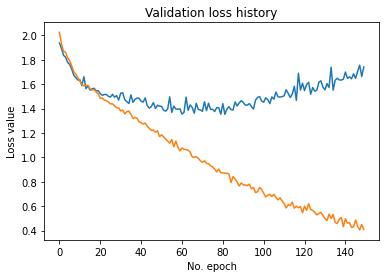

In [394]:
plt.plot(model_results[24][0].history['val_loss'])
plt.plot(model_results[24][0].history['loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

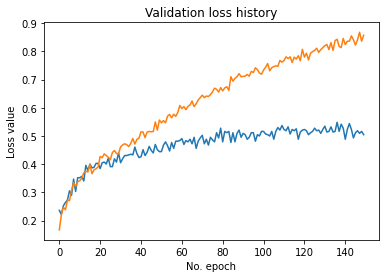

In [395]:
plt.plot(model_results[24][0].history['val_accuracy'])
plt.plot(model_results[24][0].history['accuracy'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()